In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os

In [2]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split  # EmoBank의 'split' 컬럼을 활용하지만, 일반적인 분할 예시도 보여주기 위해 남겨둡니다.

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, BertModel, get_linear_schedule_with_warmup # AutoModel은 다양한 트랜스포머 모델을 유연하게 로드

from tqdm.notebook import tqdm

from scipy.stats import pearsonr

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_DIR = "/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/dataset"

In [5]:
emobank_file_name = 'main-dataset-emobank.csv'
emobank_path = os.path.join(BASE_DIR, emobank_file_name)

In [6]:
eb = pd.read_csv(emobank_path, index_col=0, encoding='latin1')

In [7]:
print(eb.head())
print(f"\n데이터셋 전체 크기: {eb.shape}")

                              split     V     A     D  \
id                                                      
vampires_4446_4474            train  4.60  4.30  3.70   
20020731-nyt_25143_25174      train  4.56  4.00  3.78   
captured_moments_33365_33387  train  4.40  4.10  3.80   
captured_moments_28753_28863  train  4.38  3.88  3.13   
captured_moments_7553_7566    train  4.37  4.12  3.50   

                                                                           text  \
id                                                                                
vampires_4446_4474                                 lol Wonderful Simply Superb!   
20020731-nyt_25143_25174                        "I am thrilled with the price."   
captured_moments_33365_33387                             "Tell her I love her."   
captured_moments_28753_28863  For a perfect moment, Emil and Tasha and I wer...   
captured_moments_7553_7566                                        I'm in love."   

                  

In [8]:
print(eb.head(20))

                                       split     V     A     D  \
id                                                               
vampires_4446_4474                     train  4.60  4.30  3.70   
20020731-nyt_25143_25174               train  4.56  4.00  3.78   
captured_moments_33365_33387           train  4.40  4.10  3.80   
captured_moments_28753_28863           train  4.38  3.88  3.13   
captured_moments_7553_7566             train  4.37  4.12  3.50   
littleshelter2_1448_1478               train  4.37  4.37  3.18   
SemEval_759                            train  4.33  4.22  3.67   
112C-L015_1820_1880                    train  4.30  3.60  2.90   
Acephalous-Internet_1795_1799          train  4.30  4.30  3.10   
captured_moments_28728_28752           train  4.30  4.40  3.40   
detroit_11417_11443                    train  4.30  3.60  3.10   
114CUL058_1185_1212                    train  4.20  4.00  3.30   
NYTnewswire1_3167_3223                 train  4.20  4.20  3.20   
Seedbombin

In [9]:
df = eb[['text', 'V', 'A', 'D', 'split']].copy()

In [10]:
vad_columns = ['V', 'A', 'D']

print("1. V, A, D 스코어 기술 통계량:")
print(df[vad_columns].describe())

1. V, A, D 스코어 기술 통계량:
                 V            A            D
count  9436.000000  9436.000000  9436.000000
mean      2.979066     3.040692     3.063863
std       0.347496     0.258166     0.207885
min       1.200000     1.800000     1.780000
25%       2.800000     2.890000     3.000000
50%       3.000000     3.000000     3.100000
75%       3.120000     3.200000     3.200000
max       4.600000     4.400000     4.120000



2. V, A, D 스코어 분포 히스토그램:


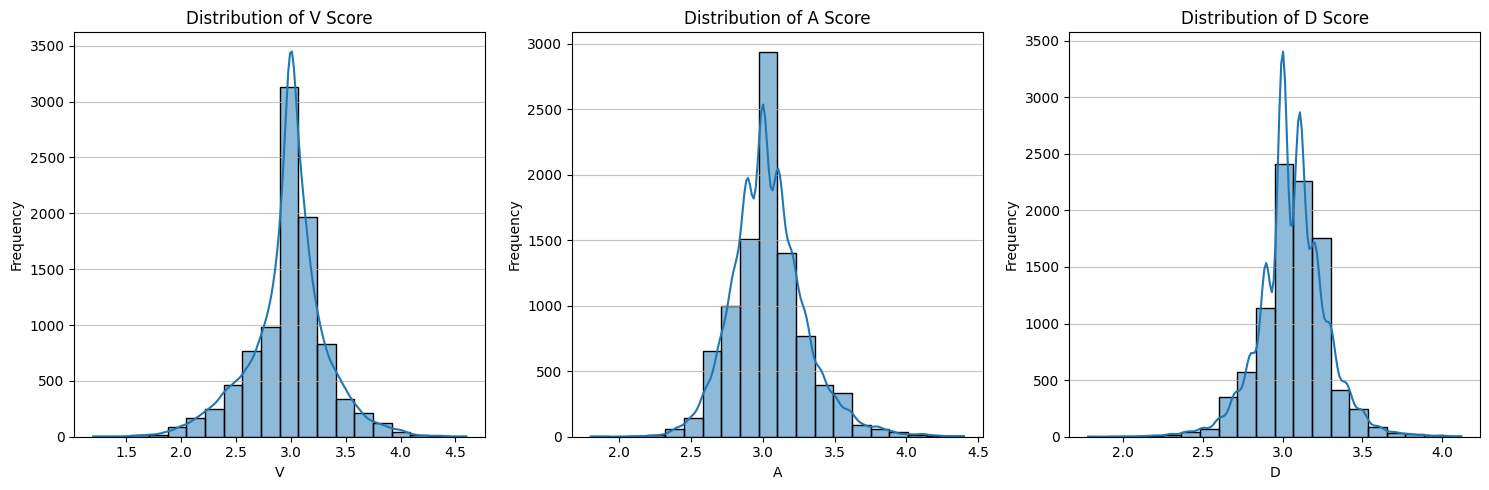

In [11]:
print("\n2. V, A, D 스코어 분포 히스토그램:")
plt.figure(figsize=(15, 5))

for i, col in enumerate(vad_columns):
    plt.subplot(1, 3, i + 1) # 1행 3열의 서브플롯
    sns.histplot(df[col], kde=True, bins=20) # kde=True로 밀도 곡선 추가
    plt.title(f'Distribution of {col} Score')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout() # 서브플롯 간 간격 자동 조절
plt.show()


3. V, A, D 스코어 커널 밀도 추정 (KDE) 플롯:


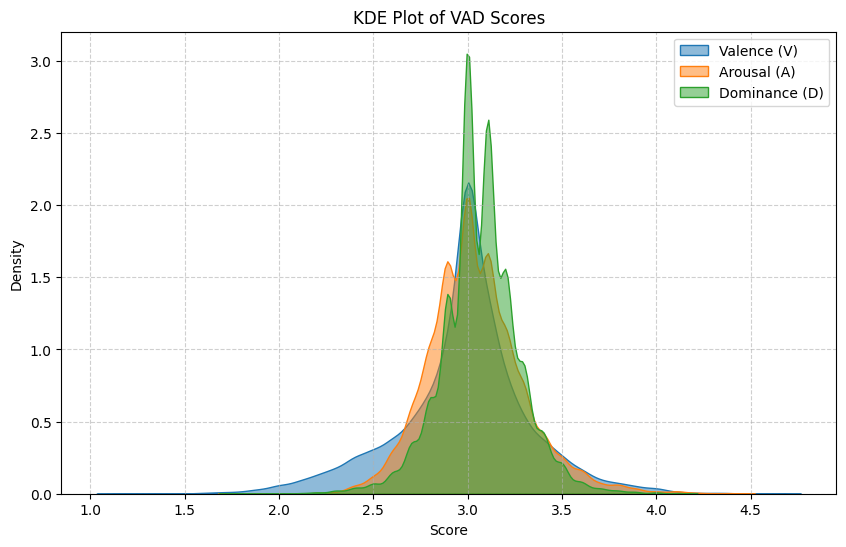

In [12]:
print("\n3. V, A, D 스코어 커널 밀도 추정 (KDE) 플롯:")
plt.figure(figsize=(10, 6))
sns.kdeplot(df['V'], label='Valence (V)', fill=True, alpha=0.5)
sns.kdeplot(df['A'], label='Arousal (A)', fill=True, alpha=0.5)
sns.kdeplot(df['D'], label='Dominance (D)', fill=True, alpha=0.5)
plt.title('KDE Plot of VAD Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




4. V, A, D 스코어의 상관 관계 (Pairplot):


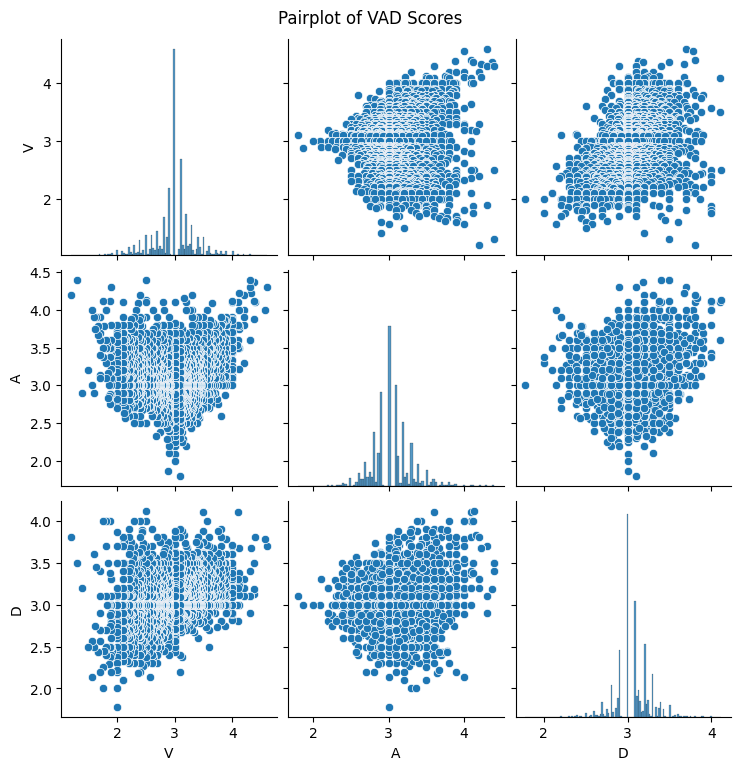

In [13]:
print("\n4. V, A, D 스코어의 상관 관계 (Pairplot):")
# 4. V, A, D 스코어 간의 관계 (Pairplot)
# 각 변수의 분포와 변수 쌍 간의 산점도를 한 번에 보여줍니다.
sns.pairplot(df[vad_columns])
plt.suptitle('Pairplot of VAD Scores', y=1.02) # 전체 제목 위치 조정
plt.show()




5. V, A, D 스코어의 상관 행렬 (Heatmap):


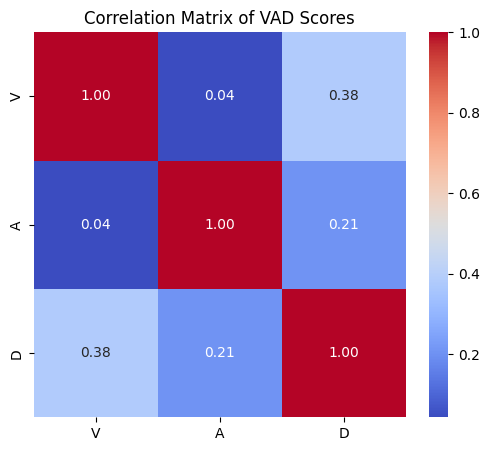

In [14]:
print("\n5. V, A, D 스코어의 상관 행렬 (Heatmap):")
# 5. 상관 행렬 히트맵
plt.figure(figsize=(6, 5))
sns.heatmap(df[vad_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of VAD Scores')
plt.show()

In [15]:
print(f"결측값 제거 전 크기: {df.shape}")

결측값 제거 전 크기: (9436, 5)


In [16]:
print(df.isnull().sum())
initial_rows = df.shape[0]
df.dropna(inplace=True)
rows_after_dropna = df.shape[0]

text     1
V        0
A        0
D        0
split    0
dtype: int64


In [17]:
print(f"결측값 제거 후 크기: {df.shape}")

결측값 제거 후 크기: (9435, 5)


In [18]:
df.head()

,text,V,A,D,split
id,,,,,
vampires_4446_4474,lol Wonderful Simply Superb!,4.60,4.30,3.70,train
20020731-nyt_25143_25174,"""I am thrilled with the price.""",4.56,4.00,3.78,train
captured_moments_33365_33387,"""Tell her I love her.""",4.40,4.10,3.80,train
captured_moments_28753_28863,"For a perfect moment, Emil and Tasha and I wer...",4.38,3.88,3.13,train
captured_moments_7553_7566,"I'm in love.""",4.37,4.12,3.50,train


In [19]:
df = df.reset_index()
df = df[['text', 'V', 'A', 'D', 'split']].copy()

In [20]:
df.head()

,text,V,A,D,split
0,lol Wonderful Simply Superb!,4.60,4.30,3.70,train
1,"""I am thrilled with the price.""",4.56,4.00,3.78,train
2,"""Tell her I love her.""",4.40,4.10,3.80,train
3,"For a perfect moment, Emil and Tasha and I wer...",4.38,3.88,3.13,train
4,"I'm in love.""",4.37,4.12,3.50,train


In [21]:
# model_name = "bert-base-uncased"  # bert는 최대 길이가 512라서 1024 시퀀스 처리 불가
model_name = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
MAX_SEQUENCE_LENGTH = 1024

In [23]:
encoded_data = tokenizer.batch_encode_plus(
        df['text'].tolist(), # 'text' 컬럼의 모든 텍스트를 리스트로 변환
        add_special_tokens=True, # [CLS], [SEP] 같은 특수 토큰 추가
        max_length=MAX_SEQUENCE_LENGTH,          # 최대 토큰 길이 (최대가 834)
        padding='max_length',    # 모든 시퀀스를 동일한 길이로 패딩
        truncation=True,         # 최대 길이를 초과하는 시퀀스 자르기
        return_attention_mask=True, # 어텐션 마스크 반환
        return_tensors='pt'      # PyTorch 텐서로 반환
    )

기존 Dataframe의 'text' column 중 가장 긴 길이

In [24]:
max_len = df['text'].str.len().max()
print("최대 길이:", max_len)

최대 길이: 834


In [25]:
input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']

print(f"\n인코딩된 input_ids의 형태: {input_ids.shape}")
print(f"인코딩된 attention_mask의 형태: {attention_mask.shape}")
print(f"첫 번째 텍스트의 input_ids 예시: {input_ids[0][:10]}...")
print(f"첫 번째 텍스트의 디코딩 예시: {tokenizer.decode(input_ids[0], skip_special_tokens=True)[:50]}...")



인코딩된 input_ids의 형태: torch.Size([9435, 1024])
인코딩된 attention_mask의 형태: torch.Size([9435, 1024])
첫 번째 텍스트의 input_ids 예시: tensor([    0, 46078, 38022, 17449,  1582,   428,   328,     2,     1,     1])...
첫 번째 텍스트의 디코딩 예시: lol Wonderful Simply Superb!...


In [26]:
print("감성 레이블(VAD)을 PyTorch 텐서로 변환")
labels = torch.tensor(df[['V', 'A', 'D']].values, dtype=torch.float32)

print(f"레이블 텐서의 형태: {labels.shape}")

감성 레이블(VAD)을 PyTorch 텐서로 변환
레이블 텐서의 형태: torch.Size([9435, 3])


In [27]:
train_indices = df[df['split'] == 'train'].index
test_indices = df[df['split'] == 'test'].index
dev_indices = df[df['split'] == 'dev'].index

In [28]:
train_input_ids = input_ids[train_indices]
train_attention_mask = attention_mask[train_indices]
train_labels = labels[train_indices]

In [29]:
test_input_ids = input_ids[test_indices]
test_attention_mask = attention_mask[test_indices]
test_labels = labels[test_indices]

In [30]:
dev_input_ids = input_ids[dev_indices]
dev_attention_mask = attention_mask[dev_indices]
dev_labels = labels[dev_indices]

In [31]:
print(f"\n학습(Train) 세트 크기: {len(train_labels)}개")
print(f"검증(Dev) 세트 크기: {len(dev_labels)}개")
print(f"테스트(Test) 세트 크기: {len(test_labels)}개")


학습(Train) 세트 크기: 7568개
검증(Dev) 세트 크기: 940개
테스트(Test) 세트 크기: 927개


In [32]:
model_name = "allenai/longformer-base-4096"

In [33]:
class EmotionRegressor(nn.Module):
    def __init__(self, model_name):
        super(EmotionRegressor, self).__init__()
        # 3-1. 사전 학습된 Transformer 모델 로드
        # AutoModel.from_pretrained()를 사용하여 지정된 model_name에 맞는 모델을 로드합니다.
        # 이 모델은 텍스트의 context-aware 임베딩을 생성합니다.
        print(f"'{model_name}' 사전 학습 모델을 로드")
        self.bert = AutoModel.from_pretrained(model_name)

        # 3-2. 회귀를 위한 Linear 레이어 추가 (출력 헤드)
        # BERT 모델의 마지막 히든 레이어 크기(보통 768)를 입력으로 받아,
        # V, A, D 세 가지 감성 값을 예측하기 위해 출력 차원을 3으로 설정합니다.
        # EmoBank의 VAD 스케일이 1-5이므로, 출력 범위에 대한 활성화 함수는 나중에 고려할 수 있습니다.
        self.regressor = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        # 3-3. Transformer 모델에 입력 전달
        # input_ids: 토큰 ID 시퀀스
        # attention_mask: 패딩 토큰을 무시하기 위한 마스크
        # outputs: Transformer 모델의 출력을 담는 객체
        # outputs.pooler_output: [CLS] 토큰에 해당하는 최종 히든 스테이트 (일반적으로 전체 문장의 요약 임베딩으로 사용)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # [CLS] 토큰의 임베딩을 문장 전체의 감성을 대표하는 벡터로 사용합니다.
        cls_embedding = outputs.pooler_output

        # 3-4. Linear 레이어를 통해 VAD 값 예측
        predictions = self.regressor(cls_embedding)
        return predictions

In [34]:
model = EmotionRegressor(model_name)

'allenai/longformer-base-4096' 사전 학습 모델을 로드


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmotionRegressor(
  (bert): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linea

### Model Params 확인

In [36]:
!pip install torchinfo

from torchinfo import summary

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [37]:
total_params = sum(p.numel() for p in model.parameters())
trainable   = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total: {total_params:,}개, Trainable: {trainable:,}개")

Total: 148,661,763개, Trainable: 148,661,763개


### DataLoader

In [38]:
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=8)
print(f"학습(Train) 데이터 로더 생성 완료. 샘플 수: {len(train_dataset)}")


학습(Train) 데이터 로더 생성 완료. 샘플 수: 7568


In [39]:
dev_dataset = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_dataset)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=8)
print(f"검증(Dev) 데이터 로더 생성 완료. 샘플 수: {len(dev_dataset)}")


검증(Dev) 데이터 로더 생성 완료. 샘플 수: 940


In [40]:
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=8)
print(f"테스트(Test) 데이터 로더 생성 완료. 샘플 수: {len(test_dataset)}")

테스트(Test) 데이터 로더 생성 완료. 샘플 수: 927


In [41]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [48]:
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
print(f"총 학습 에포크: {epochs}, 총 학습 스텝: {total_steps}")

총 학습 에포크: 4, 총 학습 스텝: 3784


In [43]:
criterion = nn.MSELoss()

In [44]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [45]:
for epoch_i in range(0, epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    # print("Training...")

    model.train()
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, b_attention_mask)

        loss = criterion(outputs, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"평균 학습 손실: {avg_train_loss:.4f}")

    # 4-5. 검증 (Validation) 단계 (dev_dataloader가 있는 경우만 실행)
    if dev_dataloader is not None:
        # print("\n검증(Validation)을 수행합니다...")
        model.eval()
        total_eval_loss = 0
        predictions_list = []
        true_labels_list = []

        for batch in tqdm(dev_dataloader, desc="Validating"):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_attention_mask)

            loss = criterion(outputs, b_labels)
            total_eval_loss += loss.item()

            predictions_list.append(outputs.cpu().numpy())
            true_labels_list.append(b_labels.cpu().numpy())

        avg_eval_loss = total_eval_loss / len(dev_dataloader)
        print(f"검증 손실: {avg_eval_loss:.4f}")

        # 평가 지표 계산 (Pearson Correlation, RMSE)
        predictions = np.concatenate(predictions_list, axis=0)
        true_labels = np.concatenate(true_labels_list, axis=0)

        v_corr = pearsonr(predictions[:, 0], true_labels[:, 0])[0]
        a_corr = pearsonr(predictions[:, 1], true_labels[:, 1])[0]
        d_corr = pearsonr(predictions[:, 2], true_labels[:, 2])[0]

        v_rmse = np.sqrt(np.mean((predictions[:, 0] - true_labels[:, 0])**2))
        a_rmse = np.sqrt(np.mean((predictions[:, 1] - true_labels[:, 1])**2))
        d_rmse = np.sqrt(np.mean((predictions[:, 2] - true_labels[:, 2])**2))

        print(f"검증 V_Corr: {v_corr:.4f}, A_Corr: {a_corr:.4f}, D_Corr: {d_corr:.4f}")
        print(f"검증 V_RMSE: {v_rmse:.4f}, A_RMSE: {a_rmse:.4f}, D_RMSE: {d_rmse:.4f}")



======== Epoch 1 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.1739


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0572
검증 V_Corr: 0.7885, A_Corr: 0.5637, D_Corr: 0.4281
검증 V_RMSE: 0.2293, A_RMSE: 0.2472, D_RMSE: 0.2369

======== Epoch 2 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0410


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0465
검증 V_Corr: 0.7992, A_Corr: 0.5768, D_Corr: 0.4713
검증 V_RMSE: 0.2372, A_RMSE: 0.2042, D_RMSE: 0.1941

======== Epoch 3 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0322


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0477
검증 V_Corr: 0.7933, A_Corr: 0.5570, D_Corr: 0.4975
검증 V_RMSE: 0.2386, A_RMSE: 0.2203, D_RMSE: 0.1839

======== Epoch 4 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0267


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0454
검증 V_Corr: 0.8075, A_Corr: 0.5772, D_Corr: 0.4903
검증 V_RMSE: 0.2148, A_RMSE: 0.2197, D_RMSE: 0.1971

======== Epoch 5 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0216


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0462
검증 V_Corr: 0.8129, A_Corr: 0.5608, D_Corr: 0.4979
검증 V_RMSE: 0.2168, A_RMSE: 0.2275, D_RMSE: 0.1941

======== Epoch 6 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0183


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0487
검증 V_Corr: 0.8079, A_Corr: 0.5573, D_Corr: 0.5007
검증 V_RMSE: 0.2260, A_RMSE: 0.2374, D_RMSE: 0.1901

======== Epoch 7 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0149


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0515
검증 V_Corr: 0.8071, A_Corr: 0.5522, D_Corr: 0.4636
검증 V_RMSE: 0.2427, A_RMSE: 0.2357, D_RMSE: 0.1940

======== Epoch 8 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0125


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0473
검증 V_Corr: 0.8096, A_Corr: 0.5402, D_Corr: 0.4636
검증 V_RMSE: 0.2176, A_RMSE: 0.2315, D_RMSE: 0.1962

======== Epoch 9 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0107


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0509
검증 V_Corr: 0.8114, A_Corr: 0.5337, D_Corr: 0.4629
검증 V_RMSE: 0.2278, A_RMSE: 0.2429, D_RMSE: 0.1986

======== Epoch 10 / 10 ========


Training:   0%|          | 0/946 [00:00<?, ?it/s]

평균 학습 손실: 0.0094


Validating:   0%|          | 0/118 [00:00<?, ?it/s]

검증 손실: 0.0497
검증 V_Corr: 0.8107, A_Corr: 0.5321, D_Corr: 0.4590
검증 V_RMSE: 0.2215, A_RMSE: 0.2396, D_RMSE: 0.2007


In [46]:
print("\n모델 학습 완료. 최종 테스트를 수행합니다...")
model.eval()
total_test_loss = 0
predictions_list = []
true_labels_list = []

for batch in tqdm(test_dataloader, desc="Testing"):
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, b_attention_mask)

    loss = criterion(outputs, b_labels)
    total_test_loss += loss.item()

    predictions_list.append(outputs.cpu().numpy())
    true_labels_list.append(b_labels.cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataloader)
print(f"최종 테스트 손실: {avg_test_loss:.4f}")

predictions = np.concatenate(predictions_list, axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

v_corr = pearsonr(predictions[:, 0], true_labels[:, 0])[0]
a_corr = pearsonr(predictions[:, 1], true_labels[:, 1])[0]
d_corr = pearsonr(predictions[:, 2], true_labels[:, 2])[0]

v_rmse = np.sqrt(np.mean((predictions[:, 0] - true_labels[:, 0])**2))
a_rmse = np.sqrt(np.mean((predictions[:, 1] - true_labels[:, 1])**2))
d_rmse = np.sqrt(np.mean((predictions[:, 2] - true_labels[:, 2])**2))

print(f"최종 테스트 V_Corr: {v_corr:.4f}, A_Corr: {a_corr:.4f}, D_Corr: {d_corr:.4f}")
print(f"최종 테스트 V_RMSE: {v_rmse:.4f}, A_RMSE: {a_rmse:.4f}, D_RMSE: {d_rmse:.4f}")

# 학습된 모델 저장 (선택 사항)
# from datetime import datetime
# current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_save_path = os.path.join(base_dir, f'emobank_emotion_regressor_{current_time}.pth')
# torch.save(model.state_dict(), model_save_path)
# print(f"학습된 모델이 다음 경로에 저장되었습니다: {model_save_path}")

print("\n[단계 4: 데이터 로더 생성 및 모델 학습/평가 완료]")


모델 학습 완료. 최종 테스트를 수행합니다...


Testing:   0%|          | 0/116 [00:00<?, ?it/s]

최종 테스트 손실: 0.0490
최종 테스트 V_Corr: 0.8104, A_Corr: 0.5048, D_Corr: 0.4987
최종 테스트 V_RMSE: 0.2231, A_RMSE: 0.2341, D_RMSE: 0.2052

[단계 4: 데이터 로더 생성 및 모델 학습/평가 완료]


## 가사 감성 분석

In [96]:
lyrics_file_name = 'main-dataset-billboard_2012_to_2022_top_100_song_lyrics.csv'
lyrics_path = os.path.join(BASE_DIR, lyrics_file_name)

In [97]:
lyrics = pd.read_csv(lyrics_path, index_col=0, encoding='latin1')

In [98]:
print(lyrics.shape)
lyrics.info()


(1100, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 2012 to 2022
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SongTitle     1100 non-null   object
 1   Artist        1100 non-null   object
 2   LyricsStatus  1100 non-null   bool  
 3   Lyrics        962 non-null    object
 4   ReleaseYear   1100 non-null   object
 5   Genre         1100 non-null   object
dtypes: bool(1), object(5)
memory usage: 52.6+ KB


In [99]:
print(lyrics.isnull().sum())
initial_rows = lyrics.shape[0]
lyrics.dropna(inplace=True)
rows_after_dropna = lyrics.shape[0]

SongTitle         0
Artist            0
LyricsStatus      0
Lyrics          138
ReleaseYear       0
Genre             0
dtype: int64


In [100]:
print(lyrics.shape)

(962, 6)


In [123]:
print(lyrics.head(1))

                SongTitle            Artist  LyricsStatus  \
Top100Year                                                  
2012        Call Me Maybe  Carly Rae Jepsen          True   

                                                       Lyrics ReleaseYear  \
Top100Year                                                                  
2012        I threw a wish in the well\nDon't ask me, I'll...        2012   

                    Genre  
Top100Year                 
2012        R&B/Soul, Pop  


In [102]:
test_lyric = lyrics.iloc[0]['Lyrics']
test_lyric

"I threw a wish in the well\nDon't ask me, I'll never tell\nI looked to you as it fell\nAnd now you're in my way\nI trade my soul for a wish\nPennies and dimes for a kiss\nI wasn't looking for this\nBut now you're in my way\nYour stare was holdin'\nRipped jeans, skin was showin'\nHot night, wind was blowin'\nWhere you think you're going, baby?\nHey, I just met you, and this is crazy\nBut here's my number, so call me, maybe\nIt's hard to look right at you, baby\nBut here's my number, so call me, maybe\nHey, I just met you, and this is crazy\nBut here's my number, so call me, maybe\nAnd all the other boys try to chase me\nBut here's my number, so call me, maybe\nYou took your time with the call\nI took no time with the fall\nYou gave me nothing at all\nBut still, you're in my way\nI beg and borrow and steal\nAt first sight, and it's real\nI didn't know I would feel it\nBut it's in my way\nYour stare was holdin'\nRipped jeans, skin was showin'\nHot night, wind was blowin'\nWhere you think

In [103]:
def split_lyrics_by_newline(lyrics):
    sentences = [s.strip() for s in lyrics.split('\n') if s.strip()]
    return sentences

In [104]:
sentences = split_lyrics_by_newline(test_lyric)
sentences

['I threw a wish in the well',
 "Don't ask me, I'll never tell",
 'I looked to you as it fell',
 "And now you're in my way",
 'I trade my soul for a wish',
 'Pennies and dimes for a kiss',
 "I wasn't looking for this",
 "But now you're in my way",
 "Your stare was holdin'",
 "Ripped jeans, skin was showin'",
 "Hot night, wind was blowin'",
 "Where you think you're going, baby?",
 'Hey, I just met you, and this is crazy',
 "But here's my number, so call me, maybe",
 "It's hard to look right at you, baby",
 "But here's my number, so call me, maybe",
 'Hey, I just met you, and this is crazy',
 "But here's my number, so call me, maybe",
 'And all the other boys try to chase me',
 "But here's my number, so call me, maybe",
 'You took your time with the call',
 'I took no time with the fall',
 'You gave me nothing at all',
 "But still, you're in my way",
 'I beg and borrow and steal',
 "At first sight, and it's real",
 "I didn't know I would feel it",
 "But it's in my way",
 "Your stare was 

In [105]:
def create_sliding_chunks(sentences, window_size=4, stride=1):
    chunks = []

    for i in range(0, len(sentences) - window_size + 1, stride):
        chunk = " ".join(sentences[i : i + window_size])
        chunks.append(chunk)
    return chunks


In [106]:
window_size = 4  # 한 번에 분석할 문장 수
stride = 1       # 다음 윈도우로 이동할 문장 수 (stride=1이면 1문장씩 겹치면서 이동)

In [107]:
lyric_chunks_sliding = create_sliding_chunks(sentences, window_size=window_size, stride=stride)
print(len(lyric_chunks_sliding))
lyric_chunks_sliding

54


["I threw a wish in the well Don't ask me, I'll never tell I looked to you as it fell And now you're in my way",
 "Don't ask me, I'll never tell I looked to you as it fell And now you're in my way I trade my soul for a wish",
 "I looked to you as it fell And now you're in my way I trade my soul for a wish Pennies and dimes for a kiss",
 "And now you're in my way I trade my soul for a wish Pennies and dimes for a kiss I wasn't looking for this",
 "I trade my soul for a wish Pennies and dimes for a kiss I wasn't looking for this But now you're in my way",
 "Pennies and dimes for a kiss I wasn't looking for this But now you're in my way Your stare was holdin'",
 "I wasn't looking for this But now you're in my way Your stare was holdin' Ripped jeans, skin was showin'",
 "But now you're in my way Your stare was holdin' Ripped jeans, skin was showin' Hot night, wind was blowin'",
 "Your stare was holdin' Ripped jeans, skin was showin' Hot night, wind was blowin' Where you think you're going,

In [108]:
input_ids_list = []
attention_mask_list = []

In [109]:
for chunk in tqdm(lyric_chunks_sliding, desc="Encoding Sliding Chunks"):
    encoded_chunk = tokenizer.batch_encode_plus(
        [chunk], # list 형태로 전달
        add_special_tokens=True, # [CLS], [SEP] 같은 특수 토큰 추가
        max_length=MAX_SEQUENCE_LENGTH, # 최대 토큰 길이
        padding='max_length',    # 모든 시퀀스를 동일한 길이로 패딩
        truncation=True,         # 최대 길이를 초과하는 시퀀스 자르기
        return_attention_mask=True, # 어텐션 마스크 반환
        return_tensors='pt'      # PyTorch 텐서로 반환
    )
    input_ids_list.append(encoded_chunk['input_ids'])
    attention_mask_list.append(encoded_chunk['attention_mask'])

Encoding Sliding Chunks:   0%|          | 0/54 [00:00<?, ?it/s]

In [110]:
# 모든 청크의 input_ids와 attention_mask를 하나의 텐서로 결합
inference_input_ids = torch.cat(input_ids_list, dim=0)
inference_attention_mask = torch.cat(attention_mask_list, dim=0)

print(f"추론을 위한 input_ids 형태: {inference_input_ids.shape}")
print(f"추론을 위한 attention_mask 형태: {inference_attention_mask.shape}")

추론을 위한 input_ids 형태: torch.Size([54, 1024])
추론을 위한 attention_mask 형태: torch.Size([54, 1024])


### 실제 Dataset에 적용

In [111]:
lyric_df = lyrics.copy()

In [149]:
# 각 노래의 시계열 VAD 점수를 저장할 딕셔너리
all_songs_vad_time_series = {}

for index, (year, row) in tqdm(enumerate(lyric_df.iterrows()), total=lyric_df.shape[0], desc="Processing Songs"):
    # print(index)
    # if index == 3:
    #     break
    song_title = row['SongTitle']
    artist = row['Artist']
    genre = row['Genre']
    lyric = row['Lyrics']

    print(f"\n[Processing Song Title: {song_title}]")

    # 1. 가사를 \n 기준으로 문장 분리
    sentences = split_lyrics_by_newline(lyric)
    if not sentences:
        print(f"  경고: {song_title} 가사에 유효한 문장이 없습니다. 건너뜁니다.")
        all_songs_vad_time_series[song_title] = np.array([]) # 빈 배열로 저장
        continue

    # 2. 슬라이딩 윈도우 방식으로 청크 생성
    window_size = 4
    stride = 1
    lyric_chunks_sliding = create_sliding_chunks(sentences, window_size=window_size, stride=stride)

    if not lyric_chunks_sliding:
        print(f"  경고: {song_title} 가사 길이가 너무 짧아 청크를 생성할 수 없습니다 (window_size={window_size}). 건너뜁니다.")
        all_songs_vad_time_series[song_title] = np.array([]) # 빈 배열로 저장
        continue
    # print(f"  생성된 슬라이딩 청크 수: {len(lyric_chunks_sliding)}개")

    # 3. 각 청크를 모델 입력 형식으로 인코딩
    input_ids_list = []
    attention_mask_list = []

    for chunk in lyric_chunks_sliding:
        encoded_chunk = tokenizer.batch_encode_plus(
            [chunk],
            add_special_tokens=True,
            max_length=MAX_SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids_list.append(encoded_chunk['input_ids'])
        attention_mask_list.append(encoded_chunk['attention_mask'])

    # 모든 청크의 input_ids와 attention_mask를 하나의 텐서로 결합
    inference_input_ids = torch.cat(input_ids_list, dim=0)
    inference_attention_mask = torch.cat(attention_mask_list, dim=0)

    # 4. 데이터 로더 생성
    inference_dataset = TensorDataset(inference_input_ids, inference_attention_mask)
    # 배치 크기는 모델의 메모리 사용량에 따라 조절
    inference_dataloader = DataLoader(inference_dataset, batch_size=8, shuffle=False)

    # 5. VAD 점수 예측
    model.eval() # 모델을 평가 모드로 설정
    predicted_vad_scores_for_song = []

    for batch in inference_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, b_attention_mask)

        predicted_vad_scores_for_song.append(outputs.cpu().numpy())

    # 예측 결과를 하나의 numpy 배열로 결합하여 저장
    if predicted_vad_scores_for_song: # 예측된 점수가 있을 경우만 concatenate
        all_songs_vad_time_series[song_title] = np.concatenate(predicted_vad_scores_for_song, axis=0)
        # print(f"  예측된 VAD 점수 형태: {all_songs_vad_time_series[song_id].shape}")
    else:
        all_songs_vad_time_series[song_title] = np.array([])
        print(f"  {song_title}에 대한 예측된 VAD 점수가 없습니다.")


print("\n모든 노래에 대한 VAD 시계열 예측 완료.")
print("예측 결과 (각 노래 ID와 VAD 시계열 배열):")
for song_title, vad_series in all_songs_vad_time_series.items():
    print(f"  {song_title}: {vad_series.shape} (VAD 시계열 데이터)")
    # print(f"    첫 2개 타임스탬프: {vad_series[:2]}")

Processing Songs:   0%|          | 0/962 [00:00<?, ?it/s]


[Processing Song Title: Call Me Maybe]

[Processing Song Title: Payphone]

[Processing Song Title: Somebody That I Used To Know]

[Processing Song Title: Wide Awake]

[Processing Song Title: Where Have You Been]

[Processing Song Title: Lights]

[Processing Song Title: We Are Young]

[Processing Song Title: Starships]

[Processing Song Title: Scream]

[Processing Song Title: Wild Ones]

[Processing Song Title: Titanium]

[Processing Song Title: Glad You Came]

[Processing Song Title: Back In Time]

[Processing Song Title: Mercy]

[Processing Song Title: Drunk On You]

[Processing Song Title: Brokenhearted]

[Processing Song Title: Boyfriend]

[Processing Song Title: Drive By]

[Processing Song Title: Springsteen]

[Processing Song Title: Stronger (What Doesn't Kill You)]

[Processing Song Title: Feel So Close]

[Processing Song Title: I Won't Give Up]

[Processing Song Title: Everybody Talks]

[Processing Song Title: Give Your Heart A Break]

[Processing Song Title: Come Over]

[Proce

In [151]:
output_dir = "/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots"
os.makedirs(output_dir, exist_ok=True)
print(f"그래프 저장 디렉토리: {output_dir}")

if not all_songs_vad_time_series:
    print("시각화할 VAD 시계열 데이터가 없습니다. `all_songs_vad_time_series` 딕셔너리가 비어 있습니다.")
else:
    for song_id, vad_series in all_songs_vad_time_series.items():
        if vad_series.size == 0:
            print(f"  경고: {song_id}에 대한 VAD 시계열 데이터가 비어 있습니다. 그래프를 그리지 않습니다.")
            continue

        # V, A, D 값 추출
        valence = vad_series[:, 0]
        arousal = vad_series[:, 1]
        dominance = vad_series[:, 2]

        # 시간축 (청크 인덱스) 생성
        time_points = np.arange(len(valence))

        # 그래프 생성
        plt.figure(figsize=(12, 6))
        plt.plot(time_points, valence, label='Valence (V)', marker='o', linestyle='-', linewidth=1.5, markersize=4)
        plt.plot(time_points, arousal, label='Arousal (A)', marker='x', linestyle='--', linewidth=1.5, markersize=4)
        plt.plot(time_points, dominance, label='Dominance (D)', marker='^', linestyle=':', linewidth=1.5, markersize=4)

        plt.title(f'VAD Time Series for Song: {song_id}')
        plt.xlabel('Time Point (Chunk Index)')
        plt.ylabel('VAD Score')
        plt.xticks(time_points) # x축 틱을 각 청크 인덱스에 맞춤
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout() # 그래프 요소들이 겹치지 않도록 자동 조정

        song_id = song_id.replace("/","-")
        # 그래프 파일로 저장
        plot_filename = os.path.join(output_dir, f'{song_id}_vad_time_series.png')
        plt.savefig(plot_filename)
        plt.close() # 현재 플롯 닫기 (메모리 절약)
        print(f"  그래프 저장됨: {plot_filename}")

print("\n모든 VAD 시계열 그래프 생성이 완료되었습니다.")

그래프 저장 디렉토리: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots
  그래프 저장됨: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots/Call Me Maybe_vad_time_series.png
  그래프 저장됨: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots/Payphone_vad_time_series.png
  그래프 저장됨: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots/Somebody That I Used To Know_vad_time_series.png
  그래프 저장됨: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots/Wide Awake_vad_time_series.png
  그래프 저장됨: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/plots/Where Have You Been_vad_time_series.png
  그래프 저장됨: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_res

ValueError: 
VAD Time Series for Song: P*$$y Fairy (OTW)
                            ^
ParseException: Expected end of text, found '$'  (at char 28), (line:1, col:29)

Error in callback <function _draw_all_if_interactive at 0x7a412ead3ce0> (for post_execute):


ValueError: 
VAD Time Series for Song: P*$$y Fairy (OTW)
                            ^
ParseException: Expected end of text, found '$'  (at char 28), (line:1, col:29)

ValueError: 
VAD Time Series for Song: P*$$y Fairy (OTW)
                            ^
ParseException: Expected end of text, found '$'  (at char 28), (line:1, col:29)

<Figure size 1200x600 with 1 Axes>

In [114]:
import json

In [161]:
output_json_dir = "/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json"
os.makedirs(output_json_dir, exist_ok=True)
print(f"JSON 결과가 저장될 디렉토리: {output_json_dir}")

def save_vad_to_json(artist,song_title, vad_time_series, lyric_chunks, output_dir):
    """
    VAD 시계열 데이터를 JSON 파일로 저장합니다.
    """
    if vad_time_series.size == 0 or not lyric_chunks or len(vad_time_series) != len(lyric_chunks):
        print(f"경고: '{song_title}'에 대한 데이터가 유효하지 않거나 길이가 일치하지 않습니다. JSON 저장을 건너뜁니다.")
        return

    try:
        overall_valence = np.mean(vad_time_series[:, 0]).item()
        overall_arousal = np.mean(vad_time_series[:, 1]).item()
        overall_dominance = np.mean(vad_time_series[:, 2]).item()

        overall_vad = {
            "valence": round(overall_valence, 2),
            "arousal": round(overall_arousal, 2),
            "dominance": round(overall_dominance, 2)
        }

        chunked_vad_list = []
        for i, (chunk_text, vad_score) in enumerate(zip(lyric_chunks, vad_time_series)):
            chunked_vad_list.append({
                "chunk_id": i + 1,
                "lyrics_text": chunk_text,
                "valence": round(vad_score[0].item(), 2),
                "arousal": round(vad_score[1].item(), 2),
                "dominance": round(vad_score[2].item(), 2)
            })

        json_data = {
            "artist" : artist,
            "overall_vad": overall_vad,
            "chunked_vad": chunked_vad_list
        }


        file_song_name = song_title.replace(" ","_")
        file_name = f"{file_song_name}_lyrics.json"
        file_path = os.path.join(output_dir, file_name)

        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)

        print(f"'{song_title}'에 대한 가사 기반 VAD 분석 결과가 '{file_path}'에 저장되었습니다.")

    except Exception as e:
        # 모든 종류의 예외를 잡아서 처리 (IOError, TypeError, KeyError 등)
        print(f"오류: '{song_title}'에 대한 JSON 저장 중 예외가 발생했습니다: {e}")
        print(f"이 곡의 JSON 저장을 건너뜁니다.")
        # 여기에 추가적인 로깅(예: 에러 로그 파일에 기록)을 할 수 있습니다.


JSON 결과가 저장될 디렉토리: /content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json


In [137]:
for k,v in all_songs_vad_time_series.items():
    print(len(v))

54
63
48


In [162]:
i = 0
for song_title, data in tqdm(all_songs_vad_time_series.items(), desc="Saving JSONs"):
    # 현재 노래 제목에 해당하는 원본 가사를 lyric_df에서 찾습니다.
    # 이 부분은 lyric_df가 pandas DataFrame이고 'SongTitle', 'Lyrics' 컬럼이 있다고 가정합니다.
    # 매칭되는 노래를 찾지 못하면 에러가 발생할 수 있으니 주의.
    try:
        original_lyrics = lyric_df[lyric_df['SongTitle'] == song_title]['Lyrics'].iloc[0]
        artist = lyric_df[lyric_df["SongTitle"] == song_title]['Artist'].iloc[0]
        i += 1
    except IndexError:
        print(f"경고: '{song_title}'에 대한 원본 가사를 lyric_df에서 찾을 수 없습니다. JSON 저장을 건너뜁니다.")
        continue

    # 원본 가사에서 청크를 다시 생성 (lyrics_text를 JSON에 포함하기 위함)
    sentences_for_json = split_lyrics_by_newline(original_lyrics)
    # window_size와 stride는 이전 예측 시 사용된 값과 동일해야 합니다.
    window_size = 4
    stride = 1
    lyric_chunks_for_json = create_sliding_chunks(sentences_for_json, window_size=window_size, stride=stride)

    print(len(lyric_chunks_for_json))
    print(len(data))
    save_vad_to_json(
        artist = artist,
        song_title=song_title,
        vad_time_series=data,
        lyric_chunks=lyric_chunks_for_json,
        output_dir=output_json_dir
    )

print("\n--- 모든 노래에 대한 JSON 파일 저장이 완료되었습니다. ---")
print(i)


Saving JSONs:   0%|          | 0/940 [00:00<?, ?it/s]

54
54
'Call Me Maybe'에 대한 가사 기반 VAD 분석 결과가 '/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json/Call_Me_Maybe_lyrics.json'에 저장되었습니다.
63
63
'Payphone'에 대한 가사 기반 VAD 분석 결과가 '/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json/Payphone_lyrics.json'에 저장되었습니다.
48
48
'Somebody That I Used To Know'에 대한 가사 기반 VAD 분석 결과가 '/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json/Somebody_That_I_Used_To_Know_lyrics.json'에 저장되었습니다.
51
51
'Wide Awake'에 대한 가사 기반 VAD 분석 결과가 '/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json/Wide_Awake_lyrics.json'에 저장되었습니다.
57
57
'Where Have You Been'에 대한 가사 기반 VAD 분석 결과가 '/content/drive/MyDrive/Ajou_ISE/4학년_1학기/B113-1 딥러닝응용/팀프로젝트 1조/lyrics_results/json/Where_Have_You_Been_lyrics.json'에 저장되었습니다.
45
45
'Lights'에 대한 가사 기반 VAD 분석 결과가 '/c

In [124]:
lyric_df[lyric_df['SongTitle'] == "Call Me Maybe"]['Lyrics'].iloc[0]

"I threw a wish in the well\nDon't ask me, I'll never tell\nI looked to you as it fell\nAnd now you're in my way\nI trade my soul for a wish\nPennies and dimes for a kiss\nI wasn't looking for this\nBut now you're in my way\nYour stare was holdin'\nRipped jeans, skin was showin'\nHot night, wind was blowin'\nWhere you think you're going, baby?\nHey, I just met you, and this is crazy\nBut here's my number, so call me, maybe\nIt's hard to look right at you, baby\nBut here's my number, so call me, maybe\nHey, I just met you, and this is crazy\nBut here's my number, so call me, maybe\nAnd all the other boys try to chase me\nBut here's my number, so call me, maybe\nYou took your time with the call\nI took no time with the fall\nYou gave me nothing at all\nBut still, you're in my way\nI beg and borrow and steal\nAt first sight, and it's real\nI didn't know I would feel it\nBut it's in my way\nYour stare was holdin'\nRipped jeans, skin was showin'\nHot night, wind was blowin'\nWhere you think